In [2]:
import os
import glob

import sklearn
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

from ana_classification import preprocess

In [3]:
sklearn.show_versions()


System:
    python: 3.7.5 (default, Dec 14 2019, 21:55:38)  [GCC 7.4.0]
executable: /home/regzand/.pyenv/versions/aca-classification/bin/python
   machine: Linux-4.15.0-72-generic-x86_64-with-debian-buster-sid

Python dependencies:
       pip: 19.3.1
setuptools: 42.0.2
   sklearn: 0.22
     numpy: 1.17.4
     scipy: 1.3.3
    Cython: None
    pandas: None
matplotlib: 3.1.2
    joblib: 0.14.1

Built with OpenMP: True


### Data loading and processing

In [4]:
files = glob.glob('data/original/*/*')
print(len(files))
files[:10]

1196


['data/original/AMA/image0249.tif',
 'data/original/AMA/AMA-1.tif',
 'data/original/AMA/AMA-3.tif',
 'data/original/AMA/image0248.tif',
 'data/original/AMA/AMA-2.tif',
 'data/original/nucleolar/image0038 - Copy.tif',
 'data/original/nucleolar/image0049 - Copy.tif',
 'data/original/nucleolar/image0048 - Copy.tif',
 'data/original/nucleolar/image0260.tif',
 'data/original/nucleolar/jaderka8.tif']

In [5]:
negatives_files = [f for f in files if 'NEG' in f]
positives_files = [f for f in files if 'NEG' not in f]

len(negatives_files), len(positives_files)

(180, 1016)

In [6]:
%%time
neg_imgs = np.array([preprocess(cv.imread(f), normalize=False, equalize=False) for f in negatives_files])
pos_imgs = np.array([preprocess(cv.imread(f), normalize=False, equalize=False) for f in positives_files])

neg_imgs.shape, pos_imgs.shape

CPU times: user 13min 55s, sys: 1.17 s, total: 13min 57s
Wall time: 3min 48s


((180, 600, 800), (1016, 600, 800))

In [7]:
pos_means = np.mean(pos_imgs.reshape(pos_imgs.shape[0], -1), axis=1)
neg_means = np.mean(neg_imgs.reshape(neg_imgs.shape[0], -1), axis=1)

pos_stds = np.std(pos_imgs.reshape(pos_imgs.shape[0], -1), axis=1)
neg_stds = np.std(neg_imgs.reshape(neg_imgs.shape[0], -1), axis=1)

In [8]:
means = np.concatenate([neg_means, pos_means])
stds = np.concatenate([neg_stds, pos_stds])

x = np.column_stack([means, stds])
y = np.array([0] * len(neg_imgs) + [1] * len(pos_imgs))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

### Data visualization

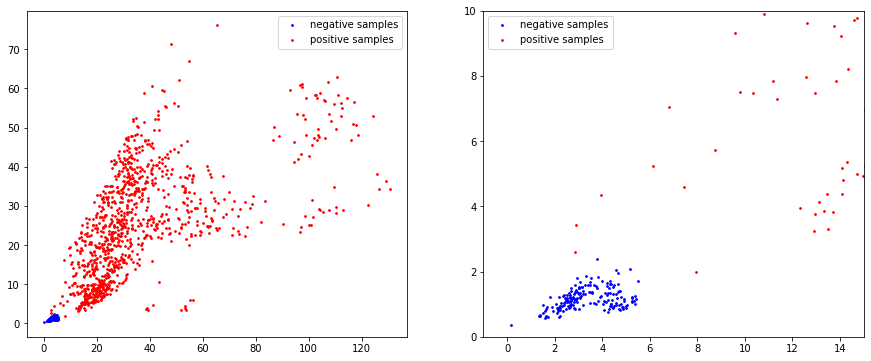

In [9]:
f, a = plt.subplots(1, 2)
f.set_size_inches(15, 6)

for ax in a:
    ax.scatter(neg_means, neg_stds, c='blue', s=3, label='negative samples')
    ax.scatter(pos_means, pos_stds, c='red', s=3, label='positive samples')
    ax.xaxis.set_label('mean pixel intentity')
    ax.yaxis.set_label('pixel intensity std')
    ax.legend()
    
a[1].set_xlim(-1, 15)
a[1].set_ylim(0, 10)

plt.show()

### Data saving

In [10]:
np.savez('neg-classifier-data.npz', x_train=x_train, y_train=y_train)

### Data loading

In [11]:
data = np.load('neg-classifier-data.npz')
x_train = data['x_train']
y_train = data['y_train']

### Classifier

In [13]:
classifier = SVC(C=0.9, kernel='poly', degree=2, gamma=0.35)
classifier.fit(x_train, y_train)

SVC(C=0.9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.35, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Decision boundary

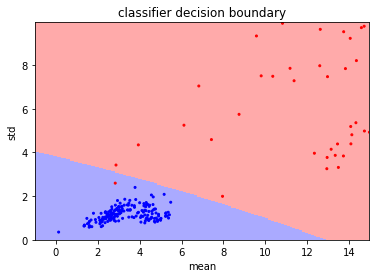

In [15]:
h = 0.05

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#0000FF', '#FF0000'])

x_min, x_max = -1, 15
y_min, y_max = 0, 10

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_bold, s=4)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('classifier decision boundary')
plt.xlabel('mean')
plt.ylabel('std')
plt.show()

### Results

In [17]:
train_preds = classifier.predict(x_train)
test_preds = classifier.predict(x_test)

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print(f'train accuracy: {train_acc}')
print(f'test accuracy: {test_acc}')

train accuracy: 1.0
test accuracy: 0.9972144846796658
